In [9]:
import numpy as np
import pylab as pl
from random import randint
from numba import njit


In [264]:
def generate_points(n_points: int):
    """returns a 2D jnumpy array with n_points randomly extracted in two dimensions

    Args:
        n_points (int): Number of points to extract
    """

    points = np.random.random((n_points, 2))

    return points


def compute_distances(points: np.ndarray):
    """Computes the distance between every row in the array.
    Each row of the array represents a point in the space

    Args:
        points (np.ndarray): Matrix which contains the points
    """

    n = points.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        distances[i] = np.linalg.norm(points[i] - points, axis=1)

    return distances


cities = generate_points(20)

distance_matrix = compute_distances(cities)


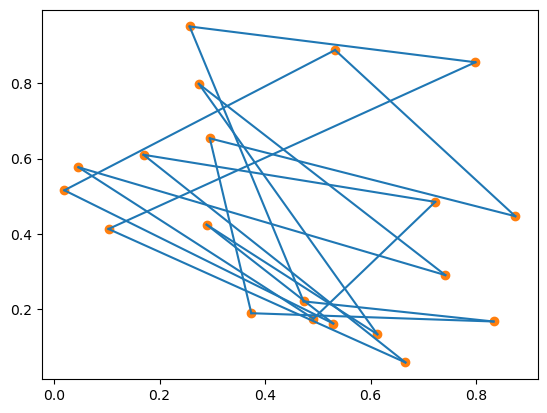

In [293]:
def plot_path(cities, path):
    x, y = cities.T
    pl.plot(x, y, 'o', color="tab:orange")

    for i in range(len(path)-1):
        data = np.stack((cities[path[i]], cities[path[i+1]]))
        pl.plot(data[:, 0], data[:, 1], color="tab:blue")

    data = np.stack((cities[path[-1]], cities[path[0]]))
    pl.plot(data[:, 0], data[:, 1], color="tab:blue")

    pl.show()


n = distance_matrix.shape[0]
path = list(range(n))
plot_path(cities, path)


In [301]:
def visit(distance_matrix, current_distance, current_city, cities_to_visit, min_length):

    n = len(cities_to_visit)

    if n == 0:
        return current_distance, [current_city]

    if current_distance + compute_bound(distance_matrix, cities_to_visit) > min_length:
        return np.inf, None

    best_path = None
    for next_city in range(n):
        length, path = visit(distance_matrix,
                       current_distance +
                       distance_matrix[current_city, next_city],
                       cities_to_visit[next_city],
                       np.delete(cities_to_visit, next_city),
                       min_length)

        if length < min_length:
            min_length = length
            best_path = path

    if best_path is None:
        return np.inf, None

    return min_length, [current_city, *best_path]


In [ ]:
def compute_bound(distance_matrix, path):
    return 0.5 * np.partition(distance_matrix[path], 2, axis=1)[:, :3].sum()


def find_shortest_path_bnb(distance_matrix):
    n = distance_matrix.shape[0]
    path = np.arange(n)
    min_length = get_path_length(distance_matrix, path)

    cities_to_visit = path.copy()

    n = len(cities_to_visit)

    best_path = None
    for start_city in range(n):
        length, path = visit(distance_matrix,
                       0.,
                       start_city,
                       np.delete(cities_to_visit, start_city),
                       min_length)

        if length < min_length:
            min_length = length
            best_path = path

    return min_length, best_path


length, path = find_shortest_path_bnb(distance_matrix)

print(length)
plot_path(cities, path)

In [367]:
@njit()
def get_path_length(distance_matrix, path, cyclic=True):
    distance = 0.
    for i in range(len(path)-1):
        distance += distance_matrix[path[i], path[i+1]]

    if not cyclic:
        return distance
    
    return distance + distance_matrix[path[-1], path[0]]


@njit()
def swap(a, i, j):
    c = a[j]
    a[j] = a[i]
    a[i] = c


3.9603737414871008


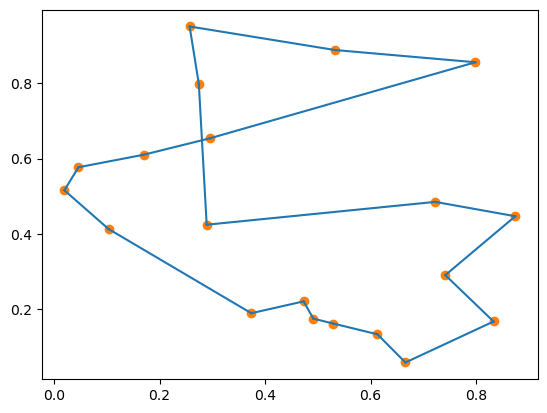

In [304]:
@njit()
def find_shortest_path_simple(distance_matrix):
    n = distance_matrix.shape[0]
    path = np.arange(n)
    min_length = get_path_length(distance_matrix, path)

    for i in range(10000):
        new_path = path.copy()
        swap(new_path, randint(0, n-1), randint(0, n-1))

        length = get_path_length(distance_matrix, new_path)
        if length < min_length:
            min_length = length
            path = new_path.copy()

    return path, min_length


path, min_length = find_shortest_path_simple(distance_matrix)

print(min_length)
plot_path(cities, path)


In [395]:
@njit()
def find_all_subsets_of_n_elements(elements, n):
    n = min(len(elements), n)
    if n == 0:
        return [[]]

    subsets = []
    for i, element in enumerate(elements):
        a = deepcopy(elements)
        a.remove(element)

        for sub_subset in find_all_subsets_of_n_elements(a, n-1):
            subsets.append([element, *sub_subset])

    return subsets


def find_shortest_path_greedy(distance_matrix, k=3):
    n = distance_matrix.shape[0]
    cities = list(range(n))
    
    best_path = []
    for i in range(n-k+1):
        paths = find_all_subsets_of_n_elements(cities, k)
        min_length = np.inf

        for path in paths:
            length = get_path_length(distance_matrix, path, cyclic=False)
            if length < min_length:
                min_length = length
                city = path[0]

        cities.remove(city)
        best_path.append(city)

    paths = find_all_subsets_of_n_elements(cities, k)
    min_length = np.inf

    for path in paths:
        length = get_path_length(distance_matrix, [*path, best_path[0]], cyclic=False)
        if length < min_length:
            min_length = length
            final_best = path

    best_path.extend(final_best)

    return best_path, get_path_length(distance_matrix, best_path)



best_path, length = find_shortest_path_greedy(distance_matrix, 3)

print(length)
plot_path(cities, best_path)

UnsupportedError: Failed in nopython mode pipeline (step: analyzing bytecode)
[1mUse of unsupported opcode (BUILD_LIST_UNPACK) found
[1m
File "<ipython-input-395-0268ced08aca>", line 13:[0m
[1mdef find_all_subsets_of_n_elements(elements, n):
    <source elided>
        for sub_subset in find_all_subsets_of_n_elements(a, n-1):
[1m            subsets.append([element, *sub_subset])
[0m            [1m^[0m[0m
[0m